In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import vis, keras


# Authenticate and create the PyDrive client.  #用來驗證
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

實作PCA

In [0]:
link1 = 'https://drive.google.com/open?id=1NIQTJ4WJloDNoxSstkutTEowPoIXvmkj'  
# Verify that you have everything after '='
fluff, id1 = link1.split('=') 

#這邊要放檔案名稱
downloaded1 = drive.CreateFile({'id':id1}) 

downloaded1.GetContentFile('Aberteen.zip')
!unzip Aberteen.zip

In [0]:
import numpy as np 
import skimage
import os
from skimage import io
from skimage.io import imread, imsave

In [0]:
img_list = []
for i in range(415):
  path = 'Aberdeen/' + str(i) + '.jpg'
  img_list.append( imread(path) )

In [0]:
#image PCA時, 是把所有data都先flatten成1D, 然後根據N筆Data求算出N*N的covariance matrix, 再做剩餘的動作

img_list_flatten = []
for i in range(415):
  img_list_flatten.append( img_list[i].flatten() )
img_arr_flatten = np.array(img_list_flatten, dtype = 'float64')

#減去均值
avg = np.mean(img_arr_flatten, axis = 0) 
img_arr_flatten -= avg

eigen_face, s, v = np.linalg.svd(img_arr_flatten.T, full_matrices = False)  # u即為eigenface

In [0]:
def process_show(M): #M為圖片（flatten之後的圖片）
  M = M.reshape(600,600,3)
  M -= np.min(M)
  M /= np.max(M)
  M = (M*255).astype(np.uint8)
  io.imshow(M)
  
def reconstruction(K): #K為數字
  weight = np.dot(img_arr_flatten[K], eigen_face) #先把新的圖片投射到這個新的坐標系, 而會呈現這張圖片在各個坐標中的「長度」
  pic = np.zeros(600*600*3)
  for i in range(5): 
    pic += weight[i] * eigen_face[:,i]
  print(pic)
  process_show(pic + avg)
    

[443099.66193652 437221.89198883 419156.42547165 ... 511690.74351295
 512183.86064296 513823.43875578]


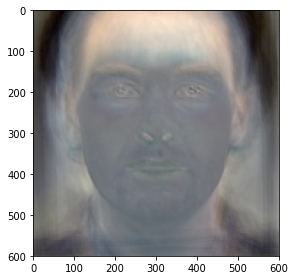

In [0]:
reconstruction(2)

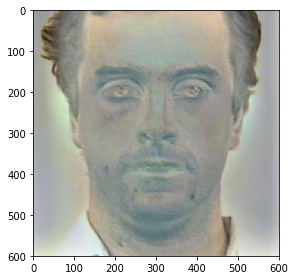

In [0]:
process_show(img_arr_flatten[19])

實作Image clustering

In [0]:
downloaded = drive.CreateFile({'id': '1QbvsIRnP3zKWvWJUeOwqzbCOZJytQFkc'}) 

downloaded.GetContentFile('images.zip') #Total 40000張, 格式：images/011708.jpg
!unzip images.zip

Archive:  images.zip
   creating: images/
  inflating: images/003301.jpg       
  inflating: images/013112.jpg       
  inflating: images/005770.jpg       
  inflating: images/015563.jpg       
  inflating: images/024966.jpg       
  inflating: images/019359.jpg       
  inflating: images/001516.jpg       
  inflating: images/030913.jpg       
  inflating: images/039089.jpg       
  inflating: images/011705.jpg       
  inflating: images/006279.jpg       
  inflating: images/008254.jpg       
  inflating: images/028184.jpg       
  inflating: images/007167.jpg       
  inflating: images/000608.jpg       
  inflating: images/018047.jpg       
  inflating: images/038397.jpg       
  inflating: images/017374.jpg       
  inflating: images/018721.jpg       
  inflating: images/026817.jpg       
  inflating: images/017412.jpg       
  inflating: images/008532.jpg       
  inflating: images/039937.jpg       
  inflating: images/007601.jpg       
  inflating: images/011063.jpg       
  inflat

In [0]:
import os
import skimage
from skimage import io
from skimage.io import imread, imsave

In [0]:
img_list = []
for i in range(1,40001):
  path = os.path.join('images', str(i).zfill(6) + '.jpg') #zfill 可以自動補零
  arr = np.array( io.imread(path), dtype = 'float64' ) #確保data type
  img_list.append(arr)
data_train = np.array(img_list) / 255 #normalization

In [0]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization, AveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers import LeakyReLU

from keras.preprocessing.image import ImageDataGenerator

In [0]:
data_train.shape

(40000, 32, 32, 3)

下面加入Noise, 增加autoencoder的抗噪能力

In [0]:
#效果太差, 會導致擷取出來的component完全跑掉
noise = np.random.normal(loc=0.5, scale=0.5, size = data_train.shape)
data_train_noise = data_train + noise
data_train_noise = np.clip(data_train_noise, 0, 1) # 把增加噪音的data回歸0,1之間

In [0]:
def identity_block(x, filters, encode, name = None):
  kernel_size = (3,3)
  pool_size = (2,2)
  kernel_initializer = keras.initializers.glorot_normal()
  
  if encode == True:
    
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = 'same', kernel_initializer = kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    if name != None: #幫中間層取名, 方便output
      x = MaxPooling2D(pool_size = pool_size, name = name)(x)
    else:
      x = MaxPooling2D(pool_size = pool_size)(x)
    return x
  
  else:
    x = UpSampling2D(size = pool_size)(x)
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = 'same',kernel_initializer = kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x  

In [0]:
input_img = Input(shape = (32, 32, 3))

encode = identity_block(input_img, 64, encode = True) #(32,32) -> (16,16)
encode = identity_block(encode, 32, encode = True) #(16,16) -> (8,8)
encode = identity_block(encode, 16, encode = True, name = 'encode') #(8, 8) -> (4, 4)

decode = identity_block(encode, 16, encode = False)
decode = identity_block(decode, 32, encode = False) #(8,8) -> (16,16)
decode = identity_block(decode, 64, encode = False) #(16,16) -> (32,32)
decode = Conv2D(filters = 3, kernel_size = (3,3), activation = 'sigmoid', padding = 'same', kernel_initializer = keras.initializers.glorot_normal())(decode)


autoencoder = Model(input_img, decode)  
autoencoder.compile(optimizer='adamax', loss='binary_crossentropy')

In [0]:
autoencoder.fit(data_train, data_train, epochs=20, batch_size=128) #從output出來的圖看起來是滿像的
#autoencoder.fit(data_train_noise, data_train, epochs=20, batch_size=128) #noise版本

Epoch 1/20
40000/40000 [==============================] - 22s 541us/step - loss: 0.5756
Epoch 2/20
40000/40000 [==============================] - 20s 494us/step - loss: 0.5637
Epoch 3/20
40000/40000 [==============================] - 20s 495us/step - loss: 0.5608
Epoch 4/20
40000/40000 [==============================] - 20s 498us/step - loss: 0.5587
Epoch 5/20
40000/40000 [==============================] - 20s 499us/step - loss: 0.5571
Epoch 6/20
40000/40000 [==============================] - 20s 493us/step - loss: 0.5558
Epoch 7/20
40000/40000 [==============================] - 20s 492us/step - loss: 0.5546
Epoch 8/20
40000/40000 [==============================] - 20s 491us/step - loss: 0.5536
Epoch 9/20
40000/40000 [==============================] - 20s 490us/step - loss: 0.5528
Epoch 10/20
40000/40000 [==============================] - 20s 492us/step - loss: 0.5520
Epoch 11/20
40000/40000 [==============================] - 20s 497us/step - loss: 0.5514
Epoch 12/20
40000/40000 [=====

In [0]:
autoencoder.summary()

In [0]:
#plot出有加入噪音或沒加入噪音時, 照片經過encoder的表現狀況

import matplotlib.pyplot as plt
def testing_autoencoder(noise): #output出三張圖, 分別是原圖 / 加入Noise的原圖 / Predict之後的圖片
  testing = autoencoder.predict(data_train[0].reshape(1,32,32,3)).reshape((32,32,3))
  if noise == True:
    fig, axes = plt.subplots(1,3,figsize=(14,5))
    axes[0].imshow(data_train[0])
    axes[1].imshow(data_train_noise[0])
    axes[2].imshow(testing)
  else:
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(data_train[0])
    axes[1].imshow(testing)
    

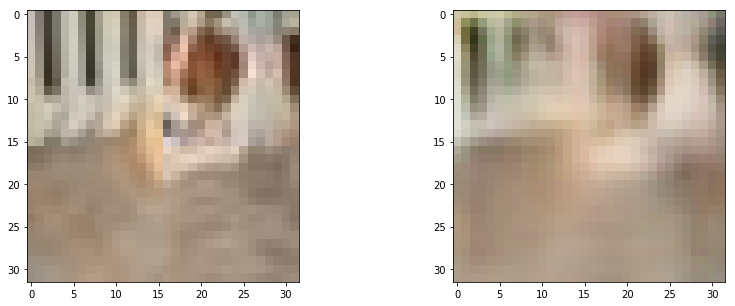

In [0]:
testing_autoencoder(noise = False)

In [0]:
#輸出中間層, 中間層的名字為 "encode"
autoencoder_dim_redu = Model(inputs = autoencoder.input, outputs = autoencoder.get_layer('encode').output)
data_dim_redu = autoencoder_dim_redu.predict(data_train)
data_dim_redu = data_dim_redu.reshape((40000, -1))

In [0]:
data_dim_redu.shape

(40000, 256)

In [0]:
#目前維度仍太多, 要先降維度再做K-Means
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

data_dim_redu_PCA = PCA(n_components = 100, copy=True, whiten = True).fit_transform(data_dim_redu)
cluster = KMeans(n_clusters=2).fit(data_dim_redu_PCA) #K-means做預測
predict = cluster.predict(data_dim_redu_PCA)

In [0]:
import pandas as pd
downloaded = drive.CreateFile({'id': '1jHqky8ed7gLg9ggOxFr8vC-cFxYBJeik'}) 
downloaded.GetContentFile('test_case.csv') 
test = pd.read_csv('test_case.csv')

In [0]:
ans = []
for i in range(test.shape[0]):
  label_1 = test.iloc[i,1] - 1
  label_2 = test.iloc[i,2] - 1
  if predict[label_1] == predict[label_2]:
    ans.append(1)
  else:
    ans.append(0)

最後的輸出

In [0]:
downloaded = drive.CreateFile({'id': '15ln8dJl2hup97R5oA3bJGrsf0kCa7xLS'}) 
downloaded.GetContentFile('sample_submission.csv')
sample_submission = pd.read_csv('sample_submission.csv', header = 0,encoding = 'unicode_escape')

In [0]:
sample_submission = sample_submission.drop(['label'], axis = 1)
sample_submission['label'] = ans

In [0]:
from google.colab import files
sample_submission.to_csv('submit.csv', index = False)
files.download('submit.csv')